# Data Loading and Normalization

In [3]:
# Helper functions for generating category-name mapping for anchors

def map_array_values(array, value_map):
    # value map must be { src : target }
    ret = array.copy()
    for src, target in value_map.items():
        ret[ret == src] = target
    return ret

def replace_binary_values(array, values):
    return map_array_values(array, {'0': values[0], '1': values[1]})

In [4]:
import numpy as np
import pandas as pd
from anchor import utils
from anchor import anchor_tabular


# scaler transform will be fitted when data is loaded in
transforms = {
            5: lambda x: replace_binary_values(x, ['No', 'Yes']),
            6: lambda x: replace_binary_values(x, ['New Vehicle', 'Used Vehicle']),
            7: lambda x: replace_binary_values(x, ['No', 'Yes']),
            10: lambda x: replace_binary_values(x, ['No', 'Yes']),
            11: lambda x: replace_binary_values(x, ['No', 'Yes']),
            12: lambda x: replace_binary_values(x, ['No', 'Yes']),
            13: lambda x: replace_binary_values(x, ['No', 'Yes']),
            14: lambda x: replace_binary_values(x, ['No', 'Yes']),
            15: lambda x: replace_binary_values(x, ['No', 'Yes']),
            16: lambda x: replace_binary_values(x, ['No', 'Yes']),
            17: lambda x: replace_binary_values(x, ['No', 'Yes']),
            18: lambda x: replace_binary_values(x, ['No', 'Yes']),
            19: lambda x: replace_binary_values(x, ['No', 'Yes']),
            20: lambda x: replace_binary_values(x, ['No', 'Yes']),
            21: lambda x: replace_binary_values(x, ['No', 'Yes']),
            22: lambda x: replace_binary_values(x, ['Not Defaulted', 'Defaulted']),
        }

In [5]:
# Load dataset using XAI data loader. This will 50/50 balance the dataset, create mappings for column categories to 
# explainable names and 80/20 split into train/test
dataset = utils.load_csv_dataset('preprocessed.csv', 22, delimiter=',', categorical_features=[5,6,7,10,11,12,13,14,15,16,17,18,19,20,21],
                 feature_transformations=transforms, discretize=False, balance=True, fill_na=0)

In [6]:
dataset.labels_train.shape

(410900,)

In [7]:
# Add axis for skorch compatability
dataset.labels_train = dataset.labels_train[:, np.newaxis]
dataset.labels_test = dataset.labels_test[:, np.newaxis]

# Cast to floats for skorch compatability
dataset.train = dataset.train.astype(np.float32)
dataset.labels_train = dataset.labels_train.astype(np.float32)
dataset.test = dataset.test.astype(np.float32)
dataset.labels_test = dataset.labels_test.astype(np.float32)

In [8]:
dataset.labels_train.shape

(410900, 1)

In [9]:
# Normalize training and test data using min-max normalization 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
dataset.train = scaler.fit_transform(dataset.train)
dataset.test = scaler.transform(dataset.test)

# Neural Network

Now that the data is prepared, we will use grid search to find good parameters for a neural network. We will base our search on the precision score on the validation set to ensure high sensitivity. This was chosen because in this domain, it is better to risk more false negatives than false positives.

In [ ]:
import torch
# Making the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#X_train = torch.from_numpy(X_train).to(device)
#y_train = torch.from_numpy(y_train).to(device)

In [ ]:
# Neural network module that can accept params we will use in our grid search
import torch.nn as nn
import torch.nn.functional as F

# modules: list of (nn activation funcs or layers) see https://pytorch.org/docs/stable/nn.html
# modules must retain proper input and output shape sequentially
class NetModule(nn.Module):
    def __init__(self, net_modules):
        super(NetModule, self).__init__()
        self.net_modules = nn.Sequential(*net_modules)
        
        
    def forward(self, x):
        x = self.net_modules(x)
        return x

In [12]:
# Set internal dimensions
input_dim = dataset.train.shape[1]
output_dim = 1 # binary classification, default or no default

In [13]:
included_modules = []

# Search Sigmoid activation with different neurons in hidden layer
included_modules.append([nn.Linear(input_dim, 50),
                          nn.Sigmoid(),
                          nn.Linear(50, output_dim)
                          ])

# Search Sigmoid activation with different neurons in hidden layer
included_modules.append([nn.Linear(input_dim, 50),
                          nn.Sigmoid(),
                          nn.Linear(50, 25),
                          nn.ReLU(),
                          nn.Linear(25, output_dim)
                          ])


# Search Sigmoid activation with different neurons in hidden layer
included_modules.append([nn.Linear(input_dim, 75),
                          nn.Sigmoid(),
                          nn.Linear(75, 50),
                          nn.ReLU(),
                          nn.Linear(50, output_dim)
                          ])

# Number of architectures
print(len(included_modules))

3


In [14]:
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
import time
import pickle

# Create sklearn scorer for use in architecture search
precision_scorer = make_scorer(precision_score)
early_stop = EarlyStopping(patience=7)

In [15]:
#initialize skorch NN classifier with default params
net = NeuralNetClassifier(
    NetModule,
    criterion= nn.BCEWithLogitsLoss(),
    optimizer=torch.optim.SGD,
    optimizer__momentum=0.95,
    iterator_train__shuffle=True,
    batch_size = len(dataset.train), 
    callbacks=[early_stop],
    device=device
)

In [16]:
# Perform grid search CV and output the best performing parameters

#parameters to test using gridsearch
params = {
    'lr': [0.2], 
    'max_epochs': [100],
    #pass parameters to NetModule constructor to set architecture
    'module__net_modules': included_modules
} 

# Perform grid search with 2-fold cross validation, will refit model at the end using best params on entire training set
gs = GridSearchCV(net, params, refit=True, cv=2, scoring=precision_scorer, verbose=10)

start_time = time.time()
gs.fit(dataset.train, dataset.labels_train)
elapsed_time = time.time() - start_time

model_output = (elapsed_time, gs) 
pickle.dump( model_output, open( "default_model.p", "wb" ) ) 

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2; 1/3] START lr=0.2, max_epochs=100, module__net_modules=[Linear(in_features=22, out_features=50, bias=True), Sigmoid(), Linear(in_features=50, out_features=1, bias=True)]
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7130       0.4996        0.6918  4.2420
      2        0.6918       0.5004        0.6970  2.4060
      3        0.6971       0.5004        0.7115  2.4900
      4        0.7116       0.5004        0.6986  2.4820
      5        0.6987       0.6244        0.6863  2.4751
      6        0.6864       0.4996        0.6982  2.4790
      7        0.6983       0.4996        0.7005  2.3680
      8        0.7007       0.4997        0.6840  2.4301
      9        0.6842       0.5004        0.6822  2.6922
     10        0.6824       0.5004        0.6918  2.5255
     11        0.6920       0.5004        0.6838  2.4760
     12        0.6840

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7129       0.4996        0.6919  2.3140
      2        0.6918       0.5004        0.6971  2.5210
      3        0.6970       0.5004        0.7116  2.6570
      4        0.7115       0.5004        0.6988  2.5610
      5        0.6986       0.6215        0.6865  2.6273
      6        0.6863       0.4996        0.6984  2.7930
      7        0.6982       0.4996        0.7008  2.7150
      8        0.7005       0.4997        0.6843  2.4670
      9        0.6840       0.5004        0.6824  2.5080
     10        0.6822       0.5004        0.6920  2.7229
     11        0.6917       0.5004        0.6840  2.4500
     12        0.6837       0.7221        0.6713  2.5070
     13        0.6709       0.5035        0.6756  2.5080
     14        0.6751       0.5000        0.6778  2.5340
     15        0.6772       0.6282        0.6646  2.5360
     16        0.6640       0.6

      2        0.7030       0.4996        0.6969  2.5130
      3        0.6969       0.4996        0.6937  2.5280
      4        0.6937       0.5004        0.6932  2.4690
      5        0.6932       0.5004        0.6944  2.4770
      6        0.6944       0.5004        0.6962  2.5040
      7        0.6962       0.5004        0.6975  2.5530
      8        0.6975       0.5004        0.6978  2.6041
      9        0.6979       0.5004        0.6971  2.5140
     10        0.6971       0.5004        0.6958  2.4790
Stopping since valid_loss has not improved in the last 7 epochs.
[CV 1/2; 2/3] END lr=0.2, max_epochs=100, module__net_modules=[Linear(in_features=22, out_features=50, bias=True), Sigmoid(), Linear(in_features=50, out_features=25, bias=True), ReLU(), Linear(in_features=25, out_features=1, bias=True)]; total time=  30.5s
[CV 2/2; 2/3] START lr=0.2, max_epochs=100, module__net_modules=[Linear(in_features=22, out_features=50, bias=True), Sigmoid(), Linear(in_features=50, out_features=2

     18        0.6669       0.7417        0.6630  2.4911
     19        0.6625       0.7412        0.6579  2.4812
     20        0.6573       0.7402        0.6518  2.4756
     21        0.6511       0.7401        0.6448  2.4945
     22        0.6439       0.7399        0.6365  2.4950
     23        0.6356       0.7406        0.6270  2.5068
     24        0.6258       0.7404        0.6160  2.5154
     25        0.6147       0.7409        0.6036  2.5219
     26        0.6020       0.7404        0.5899  2.5024
     27        0.5880       0.7415        0.5750  2.4793
     28        0.5729       0.7421        0.5596  2.5111
     29        0.5571       0.7436        0.5441  2.5109
     30        0.5414       0.7451        0.5295  2.4957
     31        0.5264       0.7469        0.5163  2.4953
     32        0.5130       0.7503        0.5051  2.5040
     33        0.5016       0.7537        0.4959  2.4940
     34        0.4922       0.7569        0.4881  2.4825
     35        0.4845       0.7

In [17]:
elapsed, gs = pickle.load( open( "default_model.p", "rb" ) )
print("Best Precision: " + str(gs.best_score_) + "\nBest Parameters: " + str(gs.best_params_))

Best Precision: 0.9756385400492267
Best Parameters: {'lr': 0.2, 'max_epochs': 100, 'module__net_modules': [Linear(in_features=22, out_features=75, bias=True), Sigmoid(), Linear(in_features=75, out_features=50, bias=True), ReLU(), Linear(in_features=50, out_features=1, bias=True)]}


In [18]:
print("Training Time: " + '{0:.5}'.format(elapsed) + ' seconds')

Training Time: 1039.0 seconds


In [19]:
y_pred = gs.predict(dataset.test)
  
print("Precision on Test Data: " + str(precision_score(dataset.labels_test, y_pred)))

Precision on Test Data: 0.9370329057445622


In [20]:
print("Accuracy: " + str(accuracy_score(dataset.labels_test, y_pred)))

Accuracy: 0.806679905768744


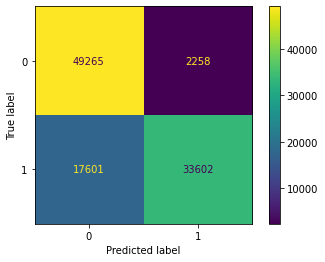

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix(dataset.labels_test, y_pred)).plot()

# Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression().fit(dataset.train, dataset.labels_train)
y_pred = log_reg.predict(dataset.test)

print("Precision on Test Data: " + str(precision_score(dataset.labels_test, y_pred)))

c:\users\kevin\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Precision on Test Data: 0.8665427430768256


c:\users\kevin\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
print("Accuracy: " + str(accuracy_score(dataset.labels_test, y_pred)))

Accuracy: 0.8393980102408348


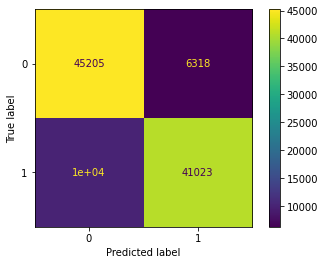

In [24]:
ConfusionMatrixDisplay(confusion_matrix(dataset.labels_test, y_pred)).plot()

# XAI Framework

In [25]:
explainer = anchor_tabular.AnchorTabularExplainer(dataset.class_names, dataset.feature_names,
                                                  dataset.train, dataset.categorical_names)

In [26]:
# Wrapper for outputting a flattened version of neural network predictions for use in explainer
def predict_and_flatten(X):
    y = gs.predict(X)
    y = y.flatten()
    return y

In [27]:
idx = 0
np.random.seed(1)
print('Neural Network Prediction: ', explainer.class_names[int(gs.predict(dataset.test[idx]))])
exp = explainer.explain_instance(dataset.test[idx], predict_and_flatten, threshold=0.95)

Neural Network Prediction:  Defaulted


In [28]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: interestRate > 0.51 AND rateSubvention = No
Precision: 0.97
Coverage: 0.49


In [29]:
print('Logistic Regression Prediction: ', explainer.class_names[int(log_reg.predict(dataset.test[idx].reshape(1, -1)))])
exp = explainer.explain_instance(dataset.test[idx], log_reg.predict, threshold=0.95)

Logistic Regression Prediction:  Defaulted


In [30]:
print('Anchor: %s' % (' AND '.join(exp.names())))
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Anchor: interestRate > 0.51 AND rateSubvention = No AND creditScore <= 0.08
Precision: 0.96
Coverage: 0.49


In [32]:
for idx in range(len(dataset.test)):
    print('Neural Network Prediction: ', explainer.class_names[int(gs.predict(dataset.test[idx]))])
    exp = explainer.explain_instance(dataset.test[idx], predict_and_flatten, threshold=0.95)
    print('Anchor: %s' % (' AND '.join(exp.names())))
    print('Precision: %.2f' % exp.precision())
    print('Coverage: %.2f' % exp.coverage())

Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.51 AND rateSubvention = No
Precision: 0.97
Coverage: 0.49
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.69 AND rateSubvention = No
Precision: 1.00
Coverage: 0.23
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.51 AND rateSubvention = No
Precision: 0.98
Coverage: 0.50
Neural Network Prediction:  Not Defaulted
Anchor: rateSubvention = Yes AND interestRate <= 0.51
Precision: 1.00
Coverage: 0.17
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.18 AND rateSubvention = Yes
Precision: 1.00
Coverage: 0.15
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.18
Precision: 0.95
Coverage: 0.25
Neural Network Prediction:  Not Defaulted
Anchor: rateSubvention = Yes AND interestRate <= 0.51
Precision: 1.00
Coverage: 0.18
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.18 AND rateSubvention = No AND 0.72 < originalLoanTerm <= 0.79
Precision: 0.95
Coverage: 0.

Anchor: interestRate <= 0.18 AND rateSubvention = Yes
Precision: 1.00
Coverage: 0.16
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.69 AND rateSubvention = No
Precision: 0.99
Coverage: 0.24
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.69 AND creditScore <= 0.06
Precision: 1.00
Coverage: 0.14
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.69 AND rateSubvention = No
Precision: 0.99
Coverage: 0.24
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.18
Precision: 0.98
Coverage: 0.25
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.51 AND rateSubvention = No
Precision: 0.98
Coverage: 0.50
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.69 AND vehicleValueAmount <= 0.07
Precision: 0.99
Coverage: 0.12
Neural Network Prediction:  Defaulted
Anchor: paymentToIncomePercentage = 0.0 AND usedIndicator = Used Vehicle AND rateSubvention = No AND underwritingIndicator = 1.0
Precision: 0.96
Coverage: 0.00
Neu

Anchor: interestRate <= 0.18 AND rateSubvention = Yes
Precision: 1.00
Coverage: 0.17
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.18 AND rateSubvention = Yes
Precision: 1.00
Coverage: 0.16
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.18 AND paymentToIncomePercentage = 0.0
Precision: 1.00
Coverage: 0.00
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.69 AND creditScore <= 0.06
Precision: 0.99
Coverage: 0.14
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.18 AND rateSubvention = No AND creditScore <= 0.08 AND Scheduled Payment Amount > 0.10 AND cashRebateSubvention = No
Precision: 0.95
Coverage: 0.33
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.69 AND rateSubvention = No
Precision: 0.99
Coverage: 0.24
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.51 AND paymentToIncomePercentage = 0.0 AND Scheduled Payment Amount <= 0.13 AND originalLoanTerm <= 0.72 AND vehicleValueAmount >

Anchor: interestRate <= 0.18 AND paymentToIncomePercentage = 0.0
Precision: 1.00
Coverage: 0.00
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.51 AND usedIndicator = Used Vehicle
Precision: 0.98
Coverage: 0.36
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.51 AND rateSubvention = No
Precision: 0.97
Coverage: 0.50
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.18
Precision: 0.98
Coverage: 0.25
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.51 AND rateSubvention = No
Precision: 0.97
Coverage: 0.50
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.51 AND rateSubvention = No
Precision: 0.98
Coverage: 0.49
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.51 AND creditScore <= 0.06
Precision: 0.98
Coverage: 0.21
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.69 AND rateSubvention = No
Precision: 0.99
Coverage: 0.24
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0

Anchor: paymentToIncomePercentage = 0.0 AND rateSubvention = No AND cashRebateSubvention = No AND originalLoanTerm > 0.72
Precision: 0.97
Coverage: 0.00
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.18 AND rateSubvention = Yes
Precision: 1.00
Coverage: 0.16
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.69 AND vehicleValueAmount <= 0.07
Precision: 1.00
Coverage: 0.12
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.69 AND rateSubvention = No
Precision: 0.99
Coverage: 0.23
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.18
Precision: 0.95
Coverage: 0.25
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.51 AND rateSubvention = No
Precision: 0.97
Coverage: 0.49
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.51 AND rateSubvention = No
Precision: 0.98
Coverage: 0.49
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.18
Precision: 0.98
Coverage: 0.25
Neural Network Prediction

Anchor: interestRate > 0.69 AND rateSubvention = No
Precision: 0.99
Coverage: 0.24
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.69 AND rateSubvention = No
Precision: 0.99
Coverage: 0.25
Neural Network Prediction:  Defaulted
Anchor: paymentToIncomePercentage = 0.0 AND interestRate > 0.18 AND usedIndicator = Used Vehicle
Precision: 0.98
Coverage: 0.00
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.69 AND rateSubvention = No
Precision: 0.99
Coverage: 0.24
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.18 AND creditScore <= 0.07 AND rateSubvention = No
Precision: 0.96
Coverage: 0.48
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.69 AND rateSubvention = No
Precision: 0.99
Coverage: 0.24
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.18 AND rateSubvention = No AND creditScore <= 0.08 AND Scheduled Payment Amount > 0.08 AND vehicleValueAmount <= 0.09
Precision: 0.97
Coverage: 0.28
Neural Network Prediction:  Def

Anchor: interestRate > 0.18 AND vehicleValueAmount <= 0.07 AND creditScore <= 0.08 AND originalLoanTerm <= 0.79
Precision: 0.97
Coverage: 0.22
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.51 AND rateSubvention = No
Precision: 0.98
Coverage: 0.50
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.18 AND rateSubvention = Yes
Precision: 1.00
Coverage: 0.16
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.51 AND paymentToIncomePercentage = 0.0 AND vehicleValueAmount > 0.09 AND creditScore > 0.07 AND originalLoanAmount > 0.06 AND Not stated, Not Verified Employment = No
Precision: 0.89
Coverage: 0.00
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.69 AND rateSubvention = No
Precision: 0.98
Coverage: 0.24
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.18
Precision: 0.96
Coverage: 0.26
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.18 AND paymentToIncomePercentage = 0.0
Precision: 1.

Anchor: interestRate > 0.51 AND rateSubvention = No
Precision: 0.97
Coverage: 0.50
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.69 AND rateSubvention = No
Precision: 0.99
Coverage: 0.24
Neural Network Prediction:  Not Defaulted
Anchor: Stated, Verified Employment = Yes AND 0.79 < originalLoanTerm <= 0.80 AND 0.08 < Scheduled Payment Amount <= 0.10 AND 0.06 < originalLoanAmount <= 0.09 AND interestRate <= 0.69 AND Not stated, Not Verified Employment = No AND otherSubvention = No AND paymentToIncomePercentage = 0.0 AND Stated, Not Verified Employment = No AND incomeVerifiedIndicator = No AND Truck = Yes AND usedIndicator = Used Vehicle AND SUV = No AND Car = No AND assetAddedIndicator = No AND gracePeriodNumber <= 0.25 AND vehicleValueAmount <= 0.07 AND coObligorIndicator = No AND underwritingIndicator = 1.0 AND creditScore <= 0.06 AND cashRebateSubvention = No
Precision: 0.95
Coverage: 0.00
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.51 AND paym

Anchor: interestRate > 0.69 AND vehicleValueAmount <= 0.07
Precision: 1.00
Coverage: 0.12
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.51 AND rateSubvention = No
Precision: 0.98
Coverage: 0.50
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.51 AND rateSubvention = No
Precision: 0.97
Coverage: 0.50
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.18 AND paymentToIncomePercentage = 0.0
Precision: 1.00
Coverage: 0.00
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.18 AND rateSubvention = No AND 0.72 < originalLoanTerm <= 0.79
Precision: 0.96
Coverage: 0.46
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.51 AND rateSubvention = No
Precision: 0.98
Coverage: 0.50
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.69 AND rateSubvention = No
Precision: 1.00
Coverage: 0.24
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.18 AND rateSubvention = No AND paymentToIncomePercentage = 0.0 AND u

Anchor: interestRate > 0.69 AND rateSubvention = No
Precision: 1.00
Coverage: 0.24
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.18
Precision: 0.95
Coverage: 0.25
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.51 AND paymentToIncomePercentage = 0.0 AND Scheduled Payment Amount <= 0.10 AND Truck = Yes AND assetAddedIndicator = No AND originalLoanTerm <= 0.72
Precision: 0.95
Coverage: 0.00
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.18 AND rateSubvention = Yes
Precision: 1.00
Coverage: 0.15
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.51 AND creditScore <= 0.06
Precision: 0.97
Coverage: 0.23
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.18
Precision: 0.96
Coverage: 0.25
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.69 AND rateSubvention = No
Precision: 0.99
Coverage: 0.25
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.51 AND rateSubvention = No
Preci

Anchor: interestRate > 0.51 AND rateSubvention = No
Precision: 0.97
Coverage: 0.50
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.18 AND creditScore > 0.08
Precision: 0.97
Coverage: 0.20
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.51 AND cashRebateSubvention = Yes
Precision: 1.00
Coverage: 0.10
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.51 AND rateSubvention = No
Precision: 0.97
Coverage: 0.49
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.18 AND creditScore <= 0.07 AND rateSubvention = No
Precision: 0.96
Coverage: 0.49
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.18 AND creditScore <= 0.07 AND originalLoanTerm <= 0.79
Precision: 0.97
Coverage: 0.42
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.69 AND rateSubvention = No
Precision: 0.99
Coverage: 0.23
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.69 AND rateSubvention = No
Precision: 1.00
Coverage: 0.24
N

Anchor: interestRate > 0.69 AND rateSubvention = No
Precision: 0.99
Coverage: 0.23
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.18 AND rateSubvention = Yes
Precision: 1.00
Coverage: 0.17
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.51 AND rateSubvention = No
Precision: 0.98
Coverage: 0.49
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.51 AND rateSubvention = No
Precision: 0.98
Coverage: 0.50
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.18
Precision: 0.98
Coverage: 0.25
Neural Network Prediction:  Defaulted
Anchor: interestRate > 0.69 AND rateSubvention = No
Precision: 0.99
Coverage: 0.24
Neural Network Prediction:  Not Defaulted
Anchor: interestRate <= 0.18 AND rateSubvention = Yes
Precision: 1.00
Coverage: 0.17
Neural Network Prediction:  Defaulted
Anchor: paymentToIncomePercentage = 0.0 AND rateSubvention = No AND cashRebateSubvention = No AND originalLoanTerm > 0.72
Precision: 0.97
Coverage: 0.00
Neural 

KeyboardInterrupt: 

# Findings and Reflection



* Need to inverse min-max normalization for better interpretability
* Need to fix splitting validation set from test set
* Class balancing method occurs before train test split. This means that test data is undersampled as well as training data